In [132]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt 


# Criando engine

In [133]:
path_db = '../db/filmes.db'

engine = create_engine(f'sqlite:///{path_db}')

In [134]:
df = pd.read_sql('SELECT * from filmes', con=engine)
df

,id,title,original_title,original_language,overview,budget,revenue,runtime,release_date,genres,popularity,vote_average,vote_count,num_genres,release_year
0,411405,Small Crimes,Small Crimes,en,"A disgraced former cop, fresh off a six-year p...",8.201666e+06,4.243626e+06,95.0,2017-04-28 00:00:00.000000,"['Drama', 'Comedy', 'Thriller', 'Crime']",7.219022,5.8,55.0,4,2017.0
1,42492,Up the Sandbox,Up the Sandbox,en,"A young wife and mother, bored with day-to-day...",3.543621e+05,2.978317e+06,97.0,1972-12-21 00:00:00.000000,"['Drama', 'Comedy']",0.138450,7.3,2.0,2,1972.0
2,12143,Bad Lieutenant,Bad Lieutenant,en,"While investigating a young nun's rape, a corr...",1.000000e+06,2.019469e+06,96.0,1992-09-16 00:00:00.000000,"['Crime', 'Drama']",6.417037,6.9,162.0,2,1992.0
3,9976,Satan's Little Helper,Satan's Little Helper,en,A naïve young boy unknowingly becomes the pawn...,1.890390e+06,1.710526e+06,100.0,2004-01-01 00:00:00.000000,"['Horror', 'Romance', 'Comedy']",2.233189,5.0,42.0,3,2004.0
4,46761,Sitcom,Sitcom,fr,The adventures of an upper-class suburban fami...,8.550376e+05,2.725346e+06,80.0,1998-05-27 00:00:00.000000,"['Comedy', 'Drama', 'Thriller']",1.800582,6.4,27.0,3,1998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,3093,Basic Instinct 2,Basic Instinct 2,en,Novelist Catherine Tramell is once again in tr...,7.000000e+07,3.862948e+07,114.0,2006-03-29 00:00:00.000000,"['Crime', 'Mystery', 'Thriller']",15.321902,4.6,183.0,3,2006.0
4994,246127,Every Thing Will Be Fine,Every Thing Will Be Fine,en,"One day, driving aimlessly around the outskirt...",9.853274e+06,8.034000e+03,118.0,2015-04-02 00:00:00.000000,['Drama'],5.723103,5.3,79.0,1,2015.0
4995,9803,Seven Dwarfs,7 Zwerge - Männer allein im Wald,de,The Seven Dwarves live deep within a female-fr...,9.674091e+06,1.694475e+06,95.0,2004-10-28 00:00:00.000000,['Comedy'],4.582736,5.2,70.0,1,2004.0
4996,336970,True Siblings,Syskonsalt,sv,"The siblings Linus, 19-years-old, who are taki...",1.060106e+06,4.436564e+06,58.0,2000-09-13 00:00:00.000000,"['Drama', 'TV Movie']",2.364355,8.0,2.0,2,2000.0


In [135]:
df['sucesso'] = df.apply(lambda x: 1 if x['revenue'] > x['budget'] else 0, axis=1)
df

,id,title,original_title,original_language,overview,budget,revenue,runtime,release_date,genres,popularity,vote_average,vote_count,num_genres,release_year,sucesso
0,411405,Small Crimes,Small Crimes,en,"A disgraced former cop, fresh off a six-year p...",8.201666e+06,4.243626e+06,95.0,2017-04-28 00:00:00.000000,"['Drama', 'Comedy', 'Thriller', 'Crime']",7.219022,5.8,55.0,4,2017.0,0
1,42492,Up the Sandbox,Up the Sandbox,en,"A young wife and mother, bored with day-to-day...",3.543621e+05,2.978317e+06,97.0,1972-12-21 00:00:00.000000,"['Drama', 'Comedy']",0.138450,7.3,2.0,2,1972.0,1
2,12143,Bad Lieutenant,Bad Lieutenant,en,"While investigating a young nun's rape, a corr...",1.000000e+06,2.019469e+06,96.0,1992-09-16 00:00:00.000000,"['Crime', 'Drama']",6.417037,6.9,162.0,2,1992.0,1
3,9976,Satan's Little Helper,Satan's Little Helper,en,A naïve young boy unknowingly becomes the pawn...,1.890390e+06,1.710526e+06,100.0,2004-01-01 00:00:00.000000,"['Horror', 'Romance', 'Comedy']",2.233189,5.0,42.0,3,2004.0,0
4,46761,Sitcom,Sitcom,fr,The adventures of an upper-class suburban fami...,8.550376e+05,2.725346e+06,80.0,1998-05-27 00:00:00.000000,"['Comedy', 'Drama', 'Thriller']",1.800582,6.4,27.0,3,1998.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,3093,Basic Instinct 2,Basic Instinct 2,en,Novelist Catherine Tramell is once again in tr...,7.000000e+07,3.862948e+07,114.0,2006-03-29 00:00:00.000000,"['Crime', 'Mystery', 'Thriller']",15.321902,4.6,183.0,3,2006.0,0
4994,246127,Every Thing Will Be Fine,Every Thing Will Be Fine,en,"One day, driving aimlessly around the outskirt...",9.853274e+06,8.034000e+03,118.0,2015-04-02 00:00:00.000000,['Drama'],5.723103,5.3,79.0,1,2015.0,0
4995,9803,Seven Dwarfs,7 Zwerge - Männer allein im Wald,de,The Seven Dwarves live deep within a female-fr...,9.674091e+06,1.694475e+06,95.0,2004-10-28 00:00:00.000000,['Comedy'],4.582736,5.2,70.0,1,2004.0,0
4996,336970,True Siblings,Syskonsalt,sv,"The siblings Linus, 19-years-old, who are taki...",1.060106e+06,4.436564e+06,58.0,2000-09-13 00:00:00.000000,"['Drama', 'TV Movie']",2.364355,8.0,2.0,2,2000.0,1


Percebemos que os dados estão desbalanceados. Assim, vamos treinar um modelo onde os dados são balanceados previamente antes do treino.  

In [136]:
df['sucesso'].value_counts(normalize=True)

sucesso
1    0.721489
0    0.278511
Name: proportion, dtype: float64

In [137]:
def avaliar_treinar_modelo_logistico(df):
    
    X = df[['budget', 'vote_average', 'popularity']].copy()
    y = df['sucesso'].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    pipeline = Pipeline([('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)), ('model', LogisticRegression(max_iter=1000 ,random_state=42))])
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scoring = ['accuracy', 'f1', 'roc_auc']
    
    resultados = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
    
    for metric in scoring:
        mean = resultados[f'test_{metric}'].mean()
        std = resultados[f'test_{metric}'].std()
        print(f"{metric.upper()}: {mean:.4f} ± {std:.4f}")
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n🔹 AUC (Area Under the Curve): {auc:.4f}")

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Aleatório (AUC = 0.5)')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC - Regressão Logística')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return pipeline

ACCURACY: 0.7209 ± 0.0143
F1: 0.7963 ± 0.0120
ROC_AUC: 0.7735 ± 0.0147
              precision    recall  f1-score   support

           0       0.48      0.61      0.53       279
           1       0.83      0.74      0.78       721

    accuracy                           0.70      1000
   macro avg       0.65      0.67      0.66      1000
weighted avg       0.73      0.70      0.71      1000


🔹 AUC (Area Under the Curve): 0.7474


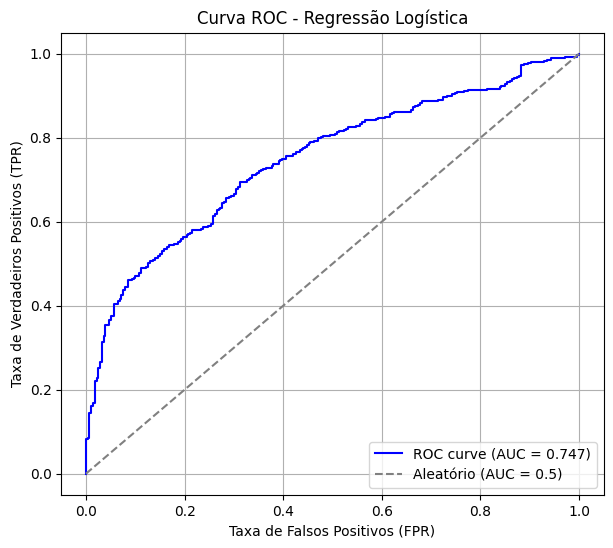

,steps,"[('scaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,penalty,'l2'


In [138]:
avaliar_treinar_modelo_logistico(df)

Analisando a __curva roc-auc__ do modelo percebemos que o modelo tem uma discriminação moderada das classes com `AUC = 0.7735`. A medida que a __ROC__ vai para o canto superior direito do gráfico o modelo tem melhor desempenho, classificando melhor os dados.

Vamos extrair o modelo dentro do pipeline para acessar os coeficientes `log-odds`.

ACCURACY: 0.7209 ± 0.0143
F1: 0.7963 ± 0.0120
ROC_AUC: 0.7735 ± 0.0147
              precision    recall  f1-score   support

           0       0.48      0.61      0.53       279
           1       0.83      0.74      0.78       721

    accuracy                           0.70      1000
   macro avg       0.65      0.67      0.66      1000
weighted avg       0.73      0.70      0.71      1000


🔹 AUC (Area Under the Curve): 0.7474


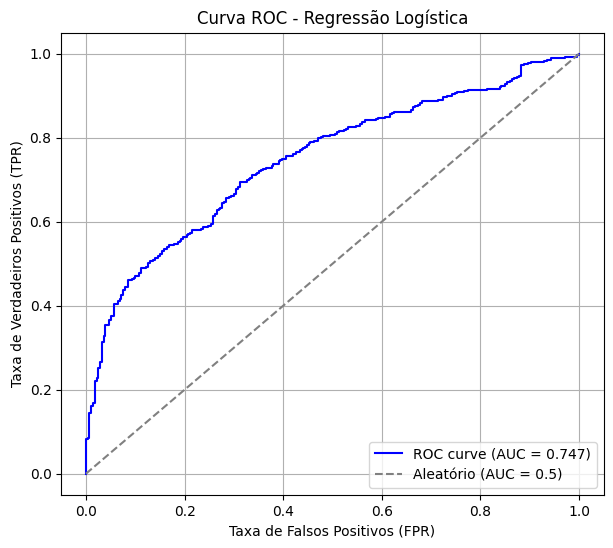

vote_average: coeficiente log_odds: -0.070261 | odds ratio: 0.932
budget: coeficiente log_odds: 0.820121 | odds ratio: 2.271
popularity: coeficiente log_odds: -1.358797 | odds ratio: 0.257


In [139]:
modelo = avaliar_treinar_modelo_logistico(df)

log_model = modelo.named_steps['model']

features = ['vote_average', 'budget', 'popularity']

for feat, coef in zip(features, log_model.coef_[0]):
    print(f'{feat}: coeficiente log_odds: {coef:.6f} | odds ratio: {np.exp(coef):.3f}')

In [140]:
df[['budget', 'vote_average', 'popularity']].corr()

,budget,vote_average,popularity
budget,1.000000,0.087278,0.307321
vote_average,0.087278,1.000000,0.105288
popularity,0.307321,0.105288,1.000000


Tetando analisar a causa do valor negativo em popularidade, plotamos a matriz que mede o grau de correlação entre essas features. Percebemos que a correlação entre elas é baixa pois a maior que existe é entre `popularity` e `budget` onde temos `0.307321`, então não temos __multicolinearidade__ nas features algo que ocorreria apenas se a correlação fosse maior do que `0.7` o que poderia ser um problema e a causa de distorcer o sinal dos coeficientes, o que não é o caso.

Então, interpretando os `coeficientes log_odds` temos que aumentando em uma unidade de `popularity` diminue a chance de `sucesso`, ou seja, a probabilidade é baixa. Aumentando a unidade de `budget` aumenta a chance de `sucesso` e por conta que `budget` tem valores extremamente altos, podem ser que tenham muito impacto na probabilidade de `sucesso`. Por fim, aumentando a unidade de `vote_average` diminue a chance de `sucesso`. 